In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm, tnrange
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import pandas as pd

In [3]:
basepath = Path('2020-11-09/').resolve()
# basepath = Path('2021-03-12_09-44-08/').resolve()
videos = list(sorted(basepath.glob('eye*.mp4')))
crop_instruct = Path(basepath / videos[0].name[6:]).with_suffix('.led_crop')
print(crop_instruct, "-- Exists:", crop_instruct.exists())

DEBUG = True

F:\data\rat_hexmaze\2020-11-09\2020-11-09_12-34-18.led_crop -- Exists: True


In [4]:
def dprint(s, show=True):
    global DEBUG
    if DEBUG and show:
        print(s)

# Extract example frames

Use these to find the center of the led visible in the image, and note `filepath, x, y` in the `.led_crop` file

Run this if there are no example images with the videos yet

In [4]:
overwrite = False
if crop_instruct.exists() and overwrite:
    print(f'Deleting existing crop file {crop_instruct}')
    crop_instruct.unlink()
    
for vid in tqdm(videos):
    cap = cv2.VideoCapture(str(vid))
    rv, frame = cap.read()
    outfile = vid.with_suffix('.png')
    if not outfile.exists() or overwrite:
        cv2.imwrite(str(vid.with_suffix('.png')), frame)

    if overwrite:
        with open(crop_instruct, 'a') as led_crop_file:
            led_crop_file.write(f'{str(vid)}, , \n')

  0%|          | 0/12 [00:00<?, ?it/s]

# Create cropped RGB image stacks around the LED centers

Can optionally create RGB and YUV stacks, though RGB turned out to be sufficient for extraction of most views

In [245]:
with open(crop_instruct) as f:
    crop_txt = f.readlines()

overwrite = True
crop = 16
FFMPEG_CMD = 'ffmpeg -hide_banner -y -i "{infile}" -vf crop={crop}:{crop}:{x}:{y} -c:v rawvideo -pix_fmt {fmt} "{outfile}"'
formats = {'rgb': 'rgb24'}  # , 'yuv': 'yuv444p'
for line in tqdm(crop_txt):
    try:
        v, x, y = line.split(',')
        x, y = int(x), int(y)
    except ValueError:
        print("Faulty line:", line, 'Maybe led coordinates are missing?')
        break
    infile = basepath / Path(v).name
    print(v, infile.exists(), x, y)
    for ext, fmt in formats.items():
        outfile = basepath / Path(v).with_suffix('.'+ext).name
        if overwrite or not outfile.exists():
            cmd = FFMPEG_CMD.format(infile=str(infile), crop=crop, x=x-crop//2, y=y-crop//2, fmt=fmt, outfile=str(outfile))
            os.system(cmd)

  0%|          | 0/12 [00:00<?, ?it/s]

F:\data\rat_hexmaze\eye01_2020-11-09_12-34-18.mp4 True 566 731
F:\data\rat_hexmaze\eye02_2020-11-09_12-34-18.mp4 True 193 731
F:\data\rat_hexmaze\eye03_2020-11-09_12-34-18.mp4 True 481 731
F:\data\rat_hexmaze\eye04_2020-11-09_12-34-18.mp4 True 117 724
F:\data\rat_hexmaze\eye05_2020-11-09_12-34-18.mp4 True 383 623
F:\data\rat_hexmaze\eye06_2020-11-09_12-34-18.mp4 True 40 607
F:\data\rat_hexmaze\eye07_2020-11-09_12-34-18.mp4 True 23 628
F:\data\rat_hexmaze\eye08_2020-11-09_12-34-18.mp4 True 392 632
F:\data\rat_hexmaze\eye09_2020-11-09_12-34-18.mp4 True 115 649
F:\data\rat_hexmaze\eye10_2020-11-09_12-34-18.mp4 True 486 650
F:\data\rat_hexmaze\eye11_2020-11-09_12-34-18.mp4 True 231 722
F:\data\rat_hexmaze\eye12_2020-11-09_12-34-18.mp4 True 568 721


In [5]:
def ica_fit(img_stack, n_components_ica=3, n_fit=10000, n_demix=-1, random_state=0, correct_polarity=True):
    """Fit ICA on image stack to extract brightness change signals.
    
    Parameters
    ----------
    img_stack : ndarray image stack of shape (w, h, 3), dtype=uint8 or floating
        Best results seen with RGB arrays.

    n_fit: int
        Maximum number of frames to fit ICA with to estimate demixing matrix. -1 to use all available frames.

    n_components_ica: int
        Number of components to use for ICA.
        
    random_state: int
        Random state for determinate output/reproducibility.

    """
    ica = FastICA(n_components=n_components_ica, random_state=random_state)
    ica.fit(img_stack.reshape(img_stack.shape[0], -1).astype(float)[:n_fit, :])  # ica_fit = 
    
    return ica

In [6]:
def ica_transform(img_stack, ica=None, n_demix=-1, correct_polarity=True, *args, **kwargs):
    """
    Parameters
    ----------
    img_stack : ndarray image stack of shape (w, h, 3), dtype=uint8 or floating
        Best results seen with RGB arrays.

    ica : None or fitted ICA model. If None, will fit with default parameters or parameters in *args and **kwargs
        
    n_demix: int
        Maximum number of frames to transform with fitted model. -1 to transform all available frames.
        
    correct_polarity: bool
        Signal sign should be positive as brightness increase corresponds to ON state of LED.
        Correct demixed signal amplitude from 
    """
    if not ica:
        ica = ica_fit(img_stack, *args, **kwargs)

    demixed = ica.transform(img_stack.reshape(img_stack.shape[0], -1).astype(float)) if n_demix else None
    
    # Check the mixing weights if the demixed signal polarity is reversed
    # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
    mix_weights_means = ica.mixing_.mean(axis=0)
    dprint(f'ICA Mix means: {mix_weights_means}')
    for nc in range(ica.n_components):
        if correct_polarity and mix_weights_means[nc] < 0:
            demixed[:, nc] = -demixed[:, nc]
            
    return demixed

In [7]:
def binarize_traces(traces, correct_polarity=True):
    """Binarize trace using kmeans with 2 components. Returns cluster id array.
    """
    binarized = np.zeros_like(traces, dtype=np.int32)
    for n in range(traces.shape[1]):
        km = KMeans(n_clusters=2, random_state=0).fit(traces[:, n].reshape(-1, 1))
        centers = km.cluster_centers_.ravel()
        binarized[:, n] = km.predict(traces[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        dprint(f'Centers: {float(centers[0]):.5f}, {float(centers[1]):.5f}', nodbg)

        if centers[0] > centers[1]:
            binarized[:, n] = np.abs(binarized[:, n]-1)
        
    return binarized

In [8]:
def led_trace(img_stack, debug=False):
    """Extract the brightness traces for red and blue leds from a stack of RGB frames using ICA and kmeans.
    
    Parameters:
    img_stack : ndarray image stack of shape (w, h, 3), dtype=uint8 or floating
        Best results seen with RGB arrays.
    
    Returns:
        Traces of extracted signals, one for each component.
    """
    demixed = ica_transform(img_stack)
#     mix_weights_means = ica.mixing_.mean(axis=0)
  
    return demixed

In [19]:
def led_quality(traces, fps=30, eD=0.5, ef_red=0.5, ef_blue=2.5, ef_qual=30):
    """Estimate signal quality for extracted brightness traces.
    
    Parameters:
    trace : ndarray of shape (n_frames, 1), dtype=floating
    
    fps : float
        Sampling rate of array to estimate signal frequency (Hz). Default 30 Hz.
    
    eD: float
        Expected duty cycle [0..1]. Default 0.5 (50%)
    
    ef_red: float
        Expected frequency of the red led (Hz). Default 0.5 Hz.
    
    ef_blue: float
        Expected frequency of the blue led (Hz). Default 2.5 Hz.
    """
    n_samples, n_traces = traces.shape
    
    dD = np.zeros(n_traces)
    df_red = np.zeros_like(dD)
    df_blue = np.zeros_like(dD)
    df_qual = np.zeros_like(dD)
    
    for n in range(n_Traces):
        bin_trace = traces[:, n]

        duty_cycle = bin_trace.sum()/len(bin_trace)
        rising_edges = np.diff(bin_trace) > 0
        frequency = rising_edges.sum()/len(bin_trace) * fps
        frequency_var = np.diff(rising_edges.nonzero()).var()
        
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        df_qual[n] = freq_qual

    quality = {'duty_cycle': 0,
               'frequency': 0,
               'isi_variance': 0}

In [10]:
def identify_traces(traces):
    pass

# Compute for all eyes
Using the first `N_ICA` frames of the RGB video patch, we compute an ICA with 3 components and apply to the full data. Two or fewer of the demixed signals should represent the brightness of the red and the blue led, but one or both might be obscured. From the mixing matrix signs we restore the polarity of the demixed signals.

Using kmeans we binarize the demixed signals, using the cluster id directly as high and low states, corrected in polarity by the cluster center locations.

With the expected signal qualities in frequency, duty cycle and low-variability in pulse length, we propose signal identities (led color) for the demixed signals.

1) ICA fit and polarity fix
2) Demix full stack
3) Cluster binarization and polarity fix
4) Signal quality and identity
5) Signal Summation

  0%|          | 0/12 [00:00<?, ?it/s]

--- eye01_2020-11-09_12-34-18.mp4 ---
ICA Mix means: [  5.12958462 923.7626332  377.5303312 ]


ValueError: not enough values to unpack (expected 2, got 1)

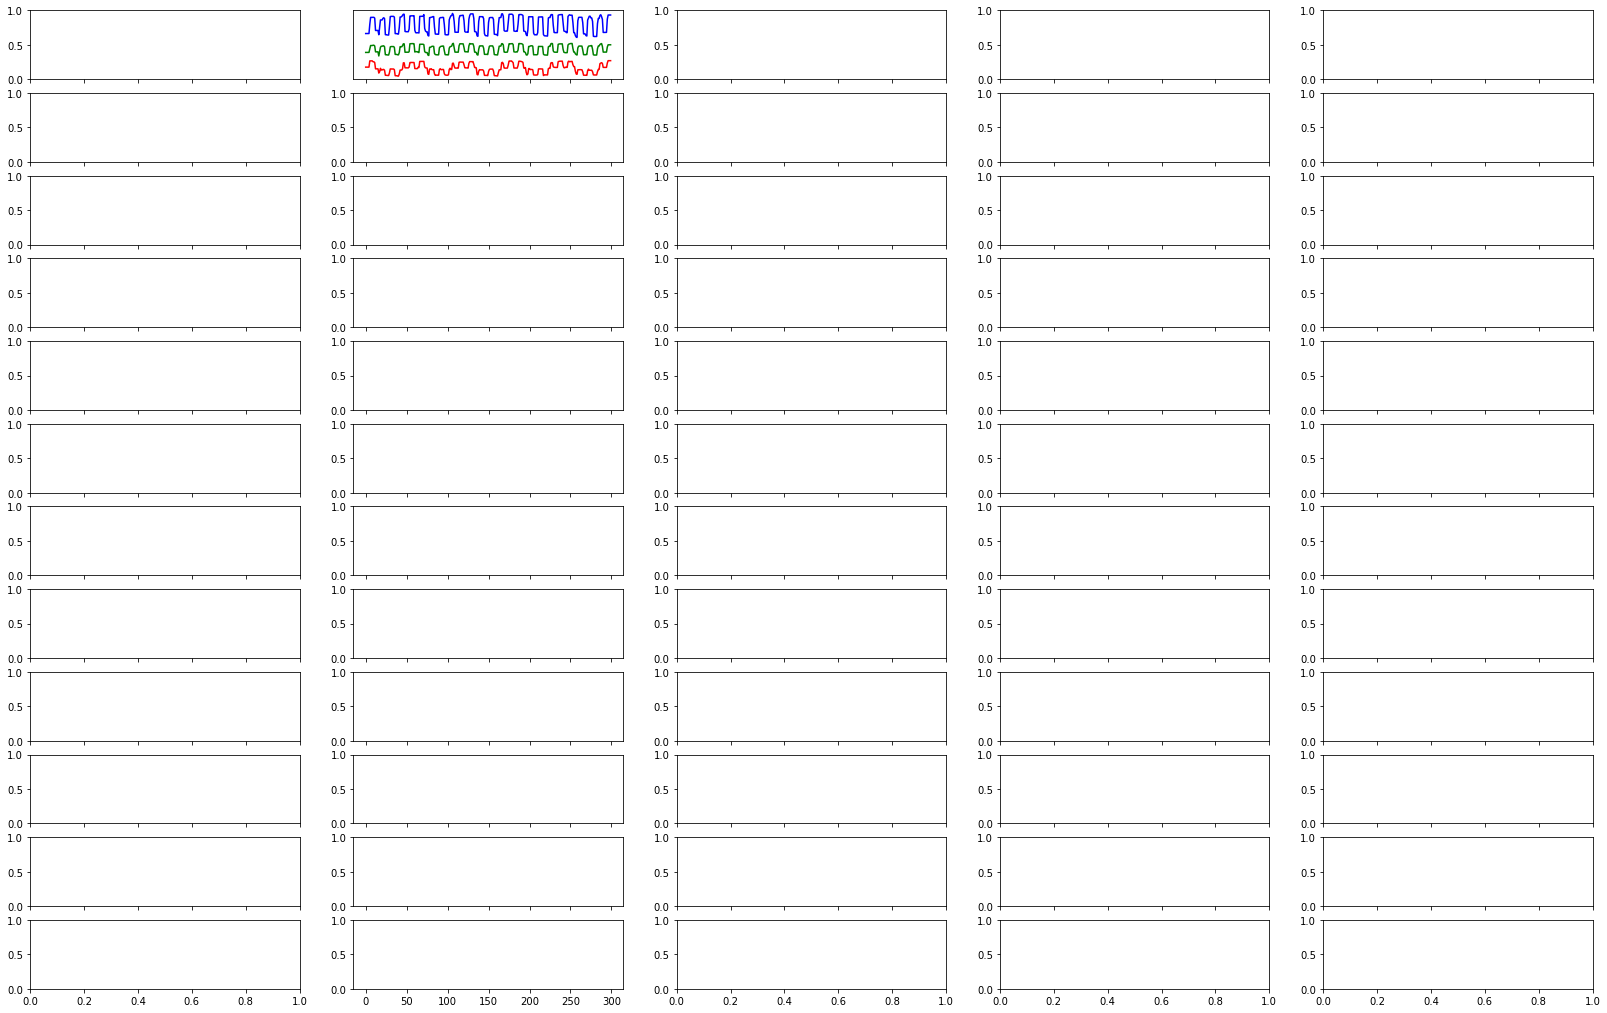

In [18]:
n_im = 12

colors = {0: 'red', 1: 'blue', None: 'gray'}
N = 300
N_ICA = 10000  # numbers of samples to use for ICA, -1 for all

DEBUG = True
nodbg = False

num_components = 3
fps = 30

fig, ax = plt.subplots(12, 5, figsize=(28, 18), sharex="col") ##  sharey=True
for eye in tnrange(12):
    dprint(f'--- {videos[eye].name} ---')
    
    # grab raw RGB stack
    rgb_frames = np.fromfile(videos[eye].with_suffix('.rgb'), dtype=np.uint8).reshape(-1, 16, 16, 3)
    
    # plot examples of led images
    for n, c in enumerate(['r', 'g', 'b']):
        ax[eye, 1].plot(rgb_frames[:N,:,:,n].astype(float).mean(axis=1).mean(axis=1)+30*n, c=c)
        ax[eye, 1].axes.yaxis.set_visible(False)
    
    # potential led signal traces
    demixed = ica_transform(rgb_frames)
    binarized = binarize_traces(demixed)

    num_components = demixed.shape[1]
    leds = np.zeros((2, rgb_frames.shape[0]), dtype=np.double)*np.nan
    led_ids = np.zeros(num_components)*np.nan
    
    quality = led_quality(binarized)
    
    for n in range(num_components):
        bin_trace = binarized[:, n]

        duty_cycle = bin_trace.sum()/len(bin_trace)
        rising_edges = np.diff(bin_trace)>0
        freq = rising_edges.sum()/len(bin_trace) * fps
        freq_qual = np.diff(rising_edges.nonzero()).var()
        
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)
        df_qual[n] = freq_qual
        
        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum() and freq_qual < ef_qual
        signal_color = good_freq.argmax() if is_signal else None
        
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]
        dprint(f'Signal: {sig_name} (D={duty_cycle*100:.2f}%, f={freq:.2f} Hz ± {freq_qual:.2f})')
        ax[eye, 3].plot(bin_trace[:N]+1.2*n, c=sig_col)
        ax[eye, 3].axes.yaxis.set_visible(False)
        

        if signal_color is not None:
            led_ids[n] = signal_color
            leds[signal_color, :] = demixed[:, n]

    np.save(videos[eye].with_suffix('.leds.npy'), leds)
        
    candidates = np.c_[dD < 0.2 * eD, df_red < ef_red * 0.1, df_blue < ef_blue * 0.1, df_qual < ef_qual, (led_ids+1)*0.5]
    ax[eye, 4].matshow(candidates)
    ax[eye, 4].set_xticks([0, 1, 2, 3, 4])
    ax[eye, 4].set_xticklabels(['D', 'f_r', 'f_b', 'f_q', 'id'])
    ax[eye, 4].set_ylabel(f'eye {eye+1:02d}')

    # Attempt to identify the ICA signal as a color LED
#     is_signal = np.logical_and(candidates[:, 0], np.sum(candidates[:, 1:]))
#     signal_color = [np.argmax(candidates[ns, 1:]) if is_signal[ns] else None for ns in range(candidates.shape[0])]
    
    rgb_arr = np.zeros((rgb_frames.shape[1], rgb_frames.shape[2]*n_im, 3), dtype=np.uint8)
    for n in range(n_im):
        rgb_arr[:,16*n:16*(n+1), :] = rgb_frames[n,:,:,:]

    ax[eye, 0].imshow(rgb_arr)
    ax[eye, 0].axes.xaxis.set_visible(False)
    ax[eye, 0].axes.yaxis.set_visible(False)
    ax[eye, 0].set_ylabel(f'eye {eye+1:02d}')

    for nc in range(num_components):
        ax[eye, 2].plot(demixed[:N,nc]+0.03*nc, c=f'C{nc:02d}')
        ax[eye, 2].axes.yaxis.set_visible(False)
    
    break
plt.tight_layout()

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(28, 18))
subfigs = fig.subfigures(12)


AttributeError: 'Figure' object has no attribute 'subfigures'

<Figure size 2016x1296 with 0 Axes>

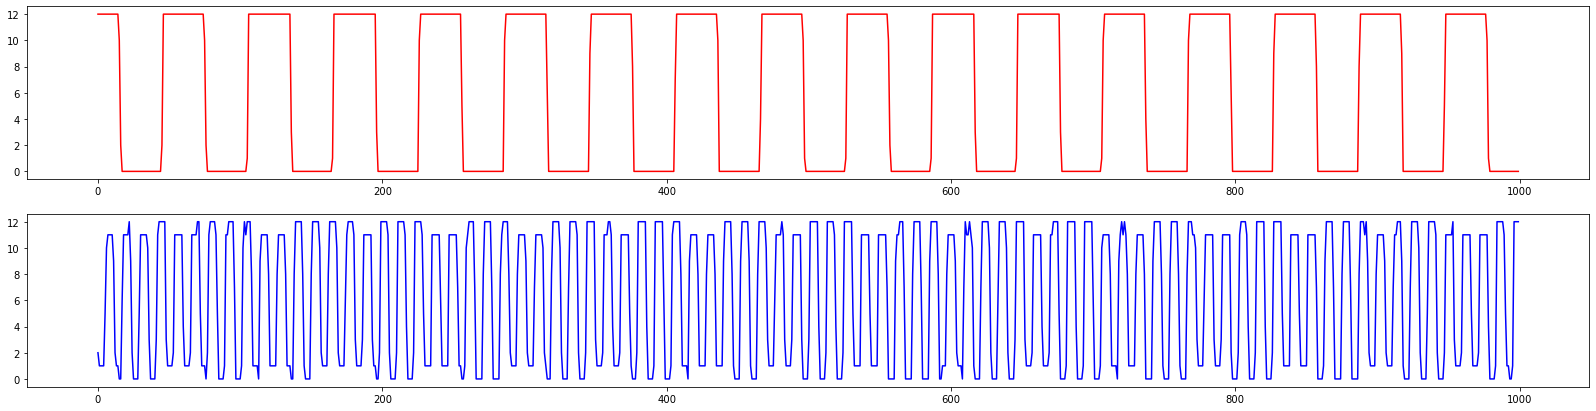

In [24]:
fig, ax = plt.subplots(2, figsize=(28, 7))
for n, c in enumerate(['r', 'b']):
    ax[n].plot(led_signals[:1000, n], c=c)

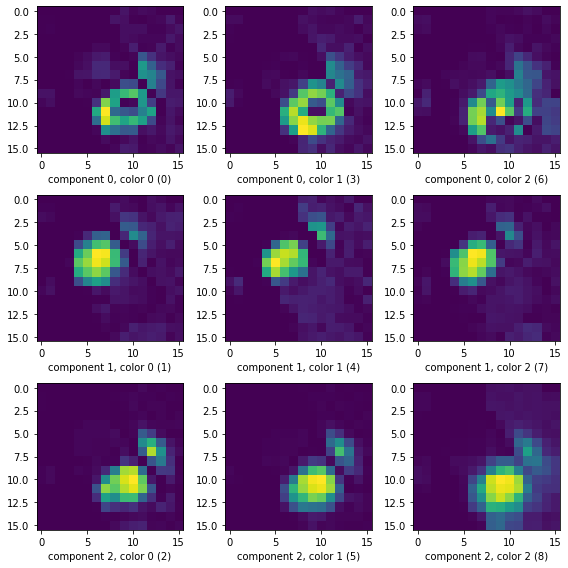

In [32]:
comp = ica.mixing_.reshape(16, 16, 3, 3)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for n in range(9):
    ax[n%3, n//3].imshow(abs(comp[:,:,n//3,n%3]))
    ax[n%3, n//3].set_xlabel(f'component {n%3}, color {n//3} ({n})')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


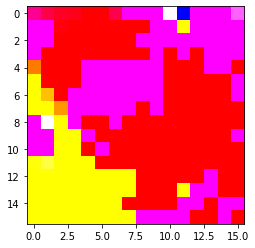

In [704]:
comp = ica.mixing_.reshape(16, 16, 3, 3)
plt.imshow(comp[:,:,0,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


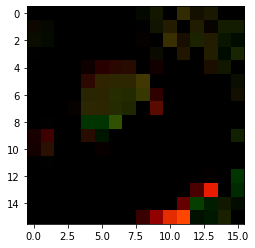

In [717]:
compmax = comp / comp.max(axis=0).max(axis=0).max(axis=0)
plt.imshow(compmax[:,:,:,2])

In [13]:
a = np.zeros((10000000,2), dtype=np.double)
b = np.zeros((2, 10000000), dtype=np.double)

In [14]:
%timeit a[:, 0] +=1

10.3 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit b[0, :] +=1

4.41 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
dur = 5
led_cmd = '''ffmpeg.exe -y -hide_banner -i  "{infile}" -vf "deblock,format=rgb24,extractplanes='b',avgblur=3,drawbox=0:0:600:75:c=0x000000:t=fill,hqdn3d,amplify=radius=8:factor=30:threshold=200:tolerance=10,tblend=c0_mode=difference,avgblur=5" -t {dur} -pix_fmt gray -f rawvideo "{outfile}"'''
for n, infile in enumerate(videos):
    cmd = led_cmd.format(infile=str(infile), outfile=str(infile.with_suffix('.led.blue')), dur=dur)
    print(cmd)
    os.system(cmd)

ffmpeg.exe -y -hide_banner -i  "F:\data\rat_hexmaze\2020-11-09\eye01_2020-11-09_12-34-18.mp4" -vf "deblock,format=rgb24,extractplanes='b',avgblur=3,drawbox=0:0:600:75:c=0x000000:t=fill,hqdn3d,amplify=radius=8:factor=30:threshold=200:tolerance=10,tblend=c0_mode=difference,avgblur=5" -t 5 -pix_fmt gray -f rawvideo "F:\data\rat_hexmaze\2020-11-09\eye01_2020-11-09_12-34-18.led.blue"
ffmpeg.exe -y -hide_banner -i  "F:\data\rat_hexmaze\2020-11-09\eye02_2020-11-09_12-34-18.mp4" -vf "deblock,format=rgb24,extractplanes='b',avgblur=3,drawbox=0:0:600:75:c=0x000000:t=fill,hqdn3d,amplify=radius=8:factor=30:threshold=200:tolerance=10,tblend=c0_mode=difference,avgblur=5" -t 5 -pix_fmt gray -f rawvideo "F:\data\rat_hexmaze\2020-11-09\eye02_2020-11-09_12-34-18.led.blue"
ffmpeg.exe -y -hide_banner -i  "F:\data\rat_hexmaze\2020-11-09\eye03_2020-11-09_12-34-18.mp4" -vf "deblock,format=rgb24,extractplanes='b',avgblur=3,drawbox=0:0:600:75:c=0x000000:t=fill,hqdn3d,amplify=radius=8:factor=30:threshold=200:tol

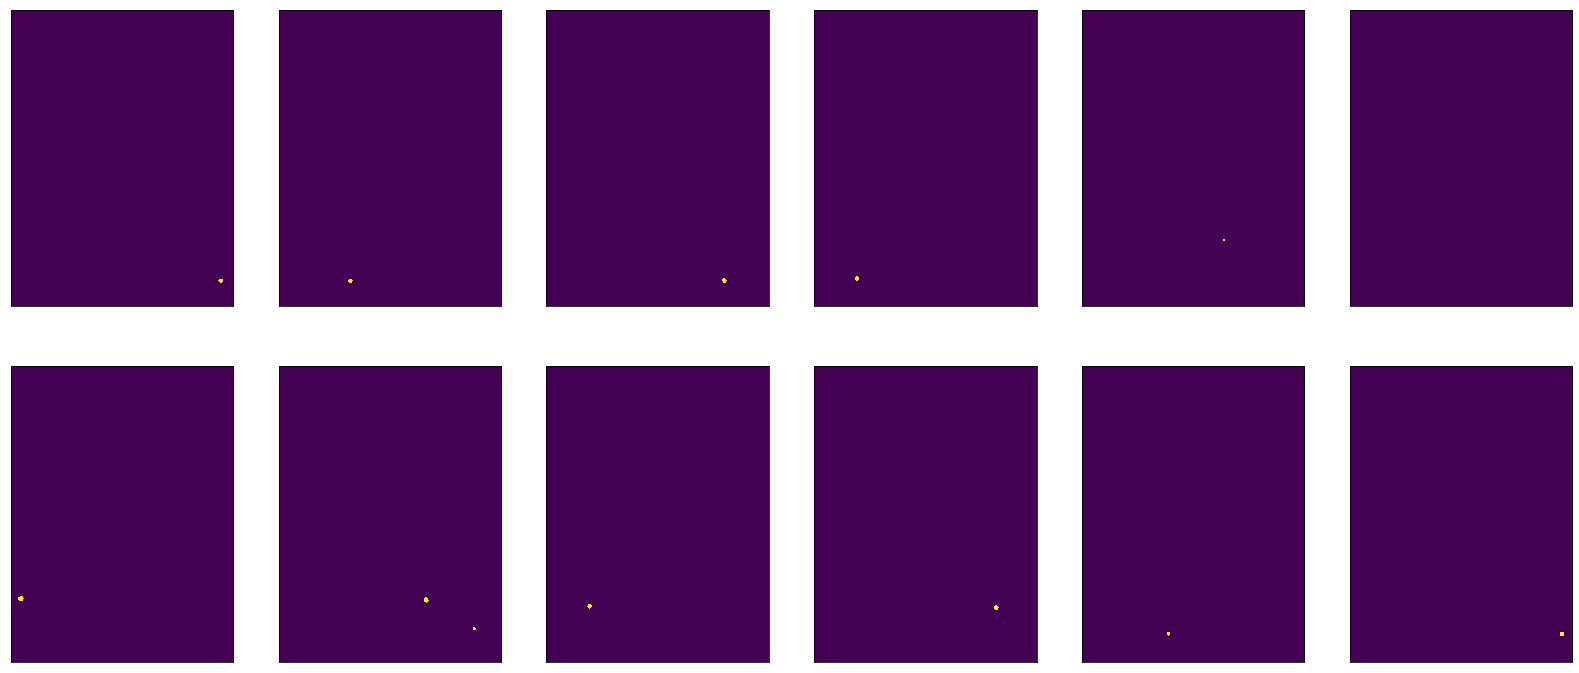

In [141]:
fig, axes = plt.subplots(2, 6, figsize=(28, 12))
for n, ax in enumerate(axes.flat):
    b = np.fromfile(videos[n].with_suffix('.led.blue'), dtype=np.uint8).reshape((-1, 800, 600))
    ax.matshow(b.var(axis=0)>1000)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [171]:
thr = 1000
bv = b.var(axis=0) > thr
bvz = np.array(bv.nonzero()).T

C:\Users\reichler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\reichler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\reichler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\reichler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak o

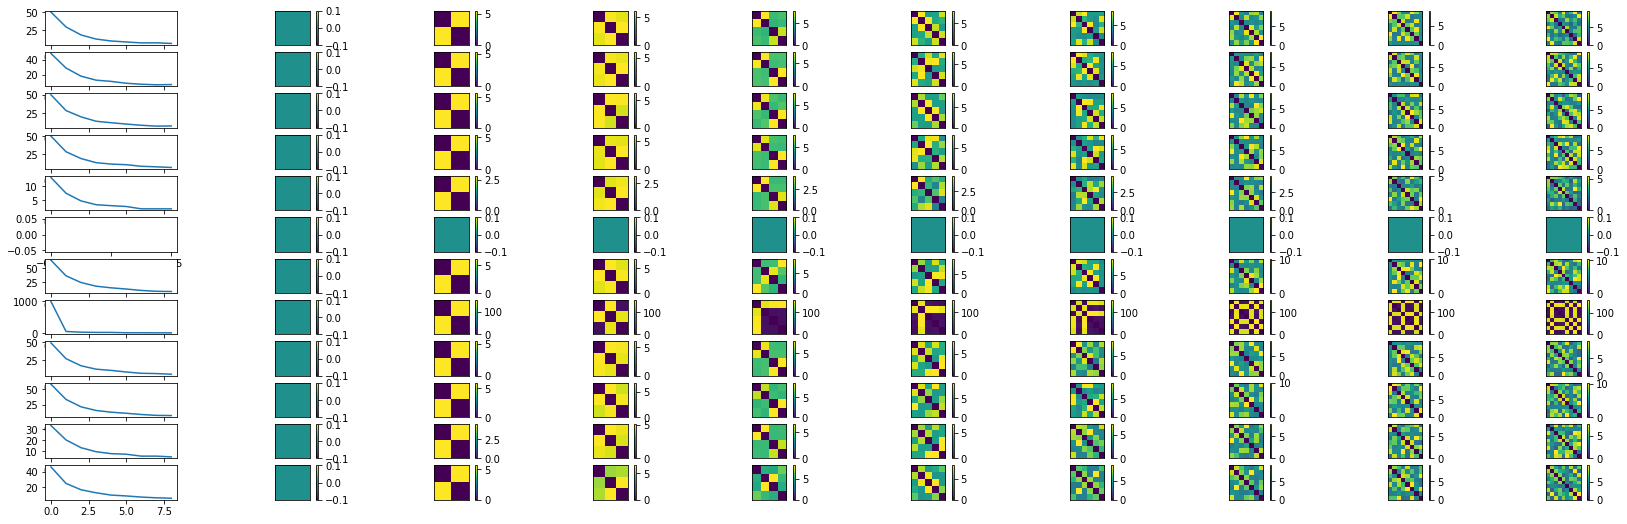

In [236]:
fig, ax = plt.subplots(12, 10, figsize=(28, 9))
for eye in range(12):
    b = np.fromfile(videos[eye].with_suffix('.led.blue'), dtype=np.uint8).reshape((-1, 800, 600))
    bv = b.var(axis=0) > thr
    bvz = np.array(bv.nonzero()).T
    d_sums = []
    for n_clu in range(1, 10):
        try:
            kmeans = KMeans(n_clusters=n_clu, random_state=0).fit(bvz)
            y_km = kmeans.predict(bvz)
            centers = kmeans.cluster_centers_
            intra_cluster_distances = []
            for n in range(n_clu):
                intra_cluster_distances.append(np.sqrt(np.sum((bvz[y_km==n, :]-centers[n])**2)))
#                 print(bvz[y_km==n, :].shape)
    #         print(f'{n:02d}: ' + ', '.join(['{:.2f}'.format(d) for d in list(intra_cluster_distances)]))
            d_sums.append(np.array(intra_cluster_distances).max())
        except ValueError:
            centers = np.zeros((3, 2))
            inter_cluster_distances = np.zeros((3, 2))

        inter_cluster_distances = pairwise_distances(centers)
        im = ax[eye, n_clu].matshow(inter_cluster_distances)
        fig.colorbar(im, ax=ax[eye, n_clu])
        ax[eye, n_clu].axes.xaxis.set_visible(False)
        ax[eye, n_clu].axes.yaxis.set_visible(False)
            
    ax[eye, 0].plot(d_sums)

# Merging Clusters

Increase cluster number while intra-cluster distances are larger than e.g. 20px. Merge clusters with inter-cluster distance of less than 10 px. Should give us a small list of candidates to be checked by ICA based led extraction.

Check candidates for signal quality, keep best.